In [1]:
import os, sys
import pandas as pd
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
import scipy as sp

In [2]:
os.chdir('../..')
cwd = os.getcwd()
DATA_PATH_ROOT = cwd
DATA_PATH = DATA_PATH_ROOT + '/data/arodz12/'
UNIPROT_ID = 'P0A7Y4'
DF_WT_SEQS = pd.read_csv(DATA_PATH + 'pw_dist_rmsd/' + UNIPROT_ID + '_wt.result')
PDBS = DF_WT_SEQS['pdb_id']
print(PDBS.tolist()) # 1zv5 and was excluded due to error in ChimeraX
pdb_list = PDBS.tolist()
sns.set_style("darkgrid")
pdb_list

['2rn2', '7vsd', '7vsa', '7vsc', '7vsb', '7vse']


['2rn2', '7vsd', '7vsa', '7vsc', '7vsb', '7vse']

In [3]:
# Define functions
def get_chi1_angles(pdb):
        pdb = md.load_pdb(pdb)
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        ch1_pos, ch1_rad = md.compute_chi1(pdb)[0], md.compute_chi1(pdb)[1]
        chi_1_angles = np.degrees(ch1_rad)
        res = [table['resName'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        n = [table['resSeq'][ch1_pos[res][-1]] for res in range(len(ch1_pos))]
        pos = [list(a) for a in zip(n,res)]
        return chi_1_angles, pos
    
def compile_angles_pdb(path):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for i in range(1,len(dir_list)):
        chi1_angle, pos = get_chi1_angles(path + dir_list[i])
        chi1_angle = chi1_angle.squeeze()
        angles_list.append(chi1_angle)
        filenames.append(dir_list[i])
        pdb = md.load_pdb(path + dir_list[i])
        topology = pdb.topology
        table, bonds = topology.to_dataframe()
        pos_list.append(pos)
    return angles_list, filenames, pos_list

# Load torsion angles for af 2
def compile_angles_af2(path, pdbs):
    filenames = list()
    dir_list = sorted(os.listdir(path))
    angles_list = list()
    pos_list = list()
    for k in range(len(dir_list)):
        for pdb in pdbs:
            if pdb in dir_list[k]:
                tmp_dir_list = os.listdir(path + '/' + dir_list[k])    
                pdb_file = [file for file in  tmp_dir_list if 'rank_1' in file and '.pdb' in file] 
                filenames.append(pdb_file[0])
                chi1_angle, pos = get_chi1_angles(path + '/' + dir_list[k] + '/' + pdb_file[0])
                chi1_angle = chi1_angle.squeeze()
                angles_list.append(chi1_angle)
                pos_list.append(pos)
    return angles_list, filenames, pos_list

def circ_meanscatter_plot(x_ls,y_ls):
    
    X = np.asarray(x_ls).ravel()
    X[X <= -120] += 360
    Y, Y_means = conv_to_np_arr_new(y_ls)
    print(X.shape, Y_means.shape)
    #values = np.vstack((X, Y))
    #kernel = gaussian_kde(values)
    #kde = kernel.evaluate(values)
    #norm = Normalize(vmin=kde.min(), vmax=kde.max())
    #colors = cm.ScalarMappable(norm=norm, cmap='viridis_r').to_rgba(kde)
    plt.title('P0A7Y4',fontsize=12)
    plt.xlabel('$\chi_1$ AF2 [$^\circ$]',fontsize=12)
    plt.ylabel('$\chi_1$ X-ray [$^\circ$]',fontsize=12)
    plt.xlim(-120,250)
    plt.ylim(-120,250)
    trend = np.polyfit(X,Y_means,1)
    trendpoly = np.poly1d(trend) 
    plt.scatter(X, Y_means)#, c=colors)
    plt.plot(X,trendpoly(X), c='black', label = 'ρ = 0.56')
    plt.legend(fontsize=14, loc="upper left")
    plt.legend(fontsize=14, loc="upper left")
    plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/chi1_plot_P0A7Y4-wt.png", dpi=1200)
    
    print(X.shape, Y_means.shape)
    return correlations_vector(X, Y_means)

def conv_to_np_arr_new(list_angles):
    mean_angles = np.array([])
    max_val = 127 #max(len(elem) for elem in list_angles)
    tmp_list = list()
    if len(list_angles) != 127:
        for i in range(len(list_angles)):
            len_ls = len(list_angles[i])
            if len_ls > 127:
                continue
            elif len_ls <= max_val:
                arr_2nan = np.empty((1,max_val-len_ls))
                arr_2nan[:] = 0
                list_angles[i] = np.append(list_angles[i],arr_2nan)
                tmp_list.append(list_angles[i])
    
    list_angles = tmp_list
    degs =  np.vstack((list_angles))
    #print('here here: ', degs[degs < -120])
    av_sin = np.mean(np.sin(degs * np.pi / 180.),axis=0)
    av_cos = np.mean(np.cos(degs * np.pi / 180.),axis=0)
    mean_angles = np.rad2deg(np.arctan2(av_sin,av_cos))
    mean_angles[mean_angles <= -120] += 360
    return list_angles, mean_angles

def correlations_vector(score1, score2):
    # Declaring y and x to append mave_data comp_data, respectively.
    y=[]; x=[]
    # Looping through NaNs and inly appending non NaNs to y and x
    for i in range(score1.shape[0]):
        if np.isnan(score1[i]) or np.isnan(score2[i]):
            pass
        else:
            x.append(float(score1[i]))
            y.append(float(score2[i]))
    # Converting to np arrays and calculating pearson and spearman correalation.
    x=np.array(x)
    y=np.array(y)
    r=sp.stats.pearsonr(x,y)
    s,p=sp.stats.spearmanr(x,y)
    print("Pearson's correlation coefficient between data: ",abs(r[0]))
    print("Spearman's correlation coefficient bewteen data: " ,abs(s))

    return [abs(r[0]),abs(s)]

In [4]:
def download_pdb(pdbcode, datadir, downloadurl="https://files.rcsb.org/download/"):
    """
    Downloads a PDB file from the Internet and saves it in a data directory.
    :param pdbcode: The standard PDB ID e.g. '3ICB' or '3icb'
    :param datadir: The directory where the downloaded file will be saved
    :param downloadurl: The base PDB download URL, cf.
        `https://www.rcsb.org/pages/download/http#structures` for details
    :return: the full path to the downloaded PDB file or None if something went wrong
    """
    pdbfn = pdbcode + ".pdb"
    url = downloadurl + pdbfn
    outfnm = os.path.join(datadir, pdbfn)
    try:
        urllib.request.urlretrieve(url, outfnm)
        return outfnm
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None


In [5]:
# Downlaod structures
#for i in range(len(PDBS)): # exclude NaN [-1]
#    print(PDBS[i])
#    download_pdb(PDBS[i], DATA_PATH + 'pdbs_wt_P0A7Y4/')

In [6]:
DF_WT_RMSD = pd.read_csv(DATA_PATH + 'pw_dist_rmsd/' + 'rmsd_wt_' + UNIPROT_ID + '.csv')
DF_WT_RMSD

,rmsd
0,2.225844
1,2.106709
2,2.077432
3,2.050978
4,2.177890


<AxesSubplot:xlabel='rmsd', ylabel='Count'>

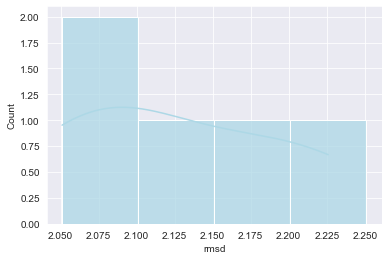

In [7]:
sns.histplot(DF_WT_RMSD, x="rmsd", binwidth=0.05, alpha=0.75, kde=True, color='lightblue', label="WT: $\mu = {}$, $\sigma = {}$".format(round(DF_WT_RMSD["rmsd"].mean(),3),round(DF_WT_RMSD["rmsd"].std(),3)))

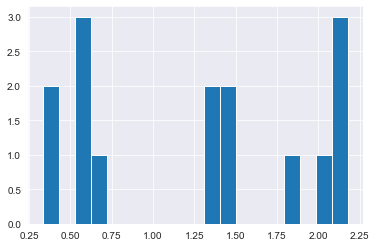

array([0.33630143, 0.41737262, 0.5435563 , 0.54683117, 0.5951597 ,
       0.66344401, 1.38996621, 1.40245097, 1.41851659, 1.45452559,
       1.85342178, 2.07743247, 2.10670896, 2.16489443, 2.17789039])

In [8]:
W = np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_P0A7Y4_wt.npy')
W_u = np.unique(np.triu(W, k=0))[1:]
num_bins = 20 # <-- Change here - Specify total number of bins for histogram
plt.hist(W_u.ravel(), bins=np.linspace(np.min(W_u), np.max(W_u), num=num_bins)) #<-- Change here.  Note the use of ravel.
plt.show()
W_u


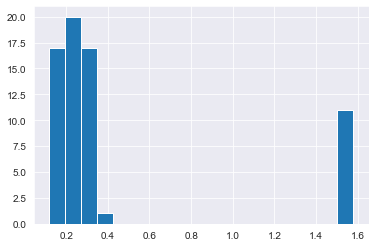

In [9]:
M =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P0A7Y4_mut.npy')
M_u = np.unique(np.triu(M, k=0))[1:] # <-- Get upper triangle of symmetric matrix
num_bins = 20 
plt.hist(M_u.ravel(), bins=np.linspace(np.min(M_u), np.max(M_u), num=num_bins)) 
plt.show()

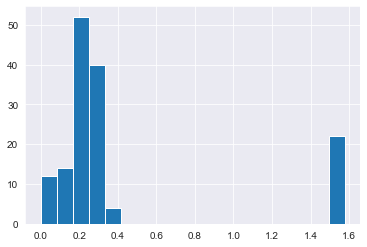

In [10]:
M =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P0A7Y4_mut.npy')
num_bins = 20  
plt.hist(M.ravel(), bins=np.linspace(np.min(M), np.max(M), num=num_bins))
plt.show()

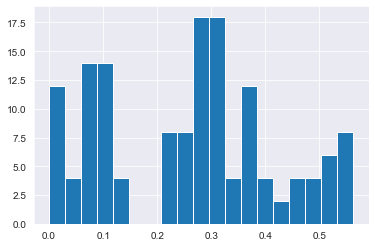

In [11]:
A =np.load(DATA_PATH + 'pw_dist_rmsd/' + 'M_pair_P0A7Y4_mut_af2.npy')
num_bins = 20  
plt.hist(A.ravel(), bins=np.linspace(np.min(A), np.max(A), num=num_bins))
plt.show()

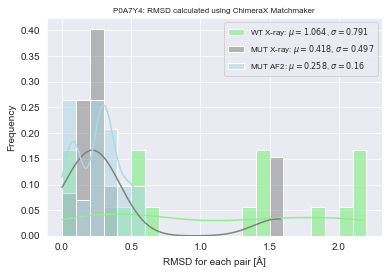

In [12]:
df_W = pd.DataFrame(W.ravel(), columns=['rmsd'])
df_M = pd.DataFrame(M.ravel(), columns=['rmsd'])
df_A = pd.DataFrame(A.ravel(), columns=['rmsd'])
sns.histplot(df_W, x="rmsd", binwidth=0.1, alpha=0.7, kde=True, color='lightgreen', label="WT X-ray: $\mu = {}$, $\sigma = {}$".format(round(df_W["rmsd"].mean(),3),round(df_W["rmsd"].std(),3)), stat = "probability")
sns.histplot(df_M, x="rmsd", binwidth=0.1, alpha=0.5, kde=True, color='grey', label="MUT X-ray: $\mu = {}$, $\sigma = {}$".format(round(df_M["rmsd"].mean(),3),round(df_M["rmsd"].std(),3)), stat = "probability")
sns.histplot(df_A, x="rmsd", binwidth=0.1, alpha=0.5, kde=True, color='lightblue', label="MUT AF2: $\mu = {}$, $\sigma = {}$".format(round(df_A["rmsd"].mean(),3),round(df_A["rmsd"].std(),3)), stat = "probability")

plt.legend(fontsize=8)
plt.title('P0A7Y4: RMSD calculated using ChimeraX Matchmaker',fontsize=8)
plt.xlabel("RMSD for each pair [Å]")
plt.ylabel("Frequency")

plt.savefig(DATA_PATH_ROOT + "/notebooks/figs/pairwise_wt_xray_mut_xray_mut_af2_P0A7Y4.pdf")
plt.show()

In [15]:
df_A.describe()

,rmsd
count,144.000000
mean,0.257572
std,0.160070
min,0.000000
25%,0.094707
50%,0.282261
75%,0.362343
max,0.562745


(0,) (127,)


TypeError: expected non-empty vector for x

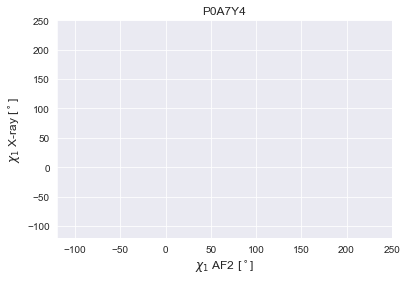

In [14]:
# Get chi 1 angles
DATA_PATH_PDB_WT = DATA_PATH + 'pdbs_wt_P0A7Y4/'
DATA_PATH_AF2_WT = DATA_PATH_ROOT + '/data/results_af2/P0A7Y4'

wt = ['2rn2']
chi_1_pdb, filenames_pdb, pos_pdb = compile_angles_pdb(DATA_PATH_PDB_WT)
chi_1_af2, filenames_af2, pos_af2 = compile_angles_af2(DATA_PATH_AF2_WT,wt)

# Plot chi_1 angles
circ_meanscatter_plot(chi_1_af2, chi_1_pdb)